<a href="https://colab.research.google.com/github/Ayatafoy/attention-based-cf/blob/main/Transformer_CF_movielens_100K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import itertools
from sklearn.metrics import mean_squared_error
tqdm.pandas()

#**Load movielens dataset**

In [ ]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

df = pd.read_csv(ratings_file)

983040/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done!


# **Exploratory Data Analysis**


In [ ]:
df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [ ]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


In [ ]:
df = df[['user', 'movie', 'rating']]

In [ ]:
movie_counts = pd.DataFrame(df['user'].value_counts()).reset_index()
movie_counts.columns = ['user', 'num_movies']

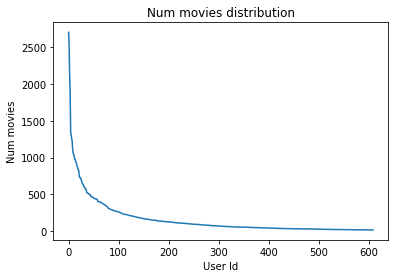

In [ ]:
plt.plot(range(len(df['user'].unique())), df['user'].value_counts().values)
plt.title('Num movies distribution')
plt.xlabel('User Id')
plt.ylabel('Num movies')
plt.show()

In [ ]:
num_movies_distribution = []
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 512]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 256]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 128]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 64]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 32]) / num_users * 100)

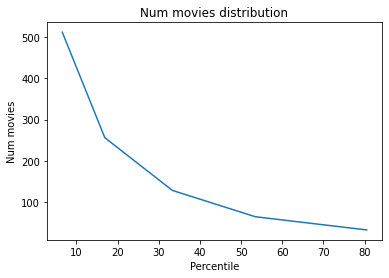

In [ ]:
plt.plot(
    [
        num_movies_distribution[4], 
        num_movies_distribution[3],
        num_movies_distribution[2], 
        num_movies_distribution[1], 
        num_movies_distribution[0]
    ], 
    [32, 64, 128, 256, 512]
)
plt.title('Num movies distribution')
plt.xlabel('Percentile')
plt.ylabel('Num movies')
plt.show()

In [ ]:
user_counts = pd.DataFrame(df['movie'].value_counts()).reset_index()
user_counts.columns = ['movie', 'num_users']

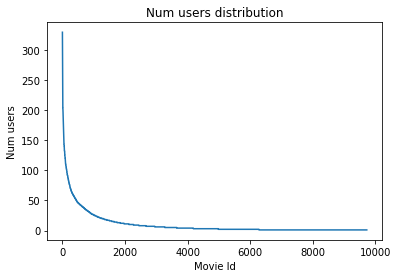

In [ ]:
plt.plot(range(len(df['movie'].unique())), df['movie'].value_counts().values)
plt.title('Num users distribution')
plt.xlabel('Movie Id')
plt.ylabel('Num users')
plt.show()

In [ ]:
num_users_distribution = []
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 2048]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 1024]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 512]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 256]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 128]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 64]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 32]) / num_movies * 100)

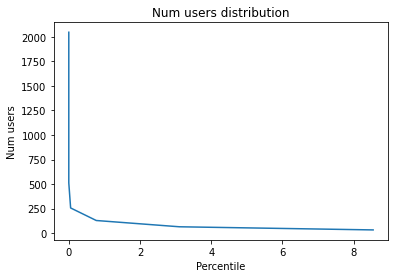

In [ ]:
plt.plot(
    [
        num_users_distribution[6],
        num_users_distribution[5],
        num_users_distribution[4], 
        num_users_distribution[3],
        num_users_distribution[2], 
        num_users_distribution[1], 
        num_users_distribution[0]
    ], 
    [32, 64, 128, 256, 512, 1024, 2048]
)
plt.title('Num users distribution')
plt.xlabel('Percentile')
plt.ylabel('Num users')
plt.show()

In [ ]:
print(f'Sparsity:{1 - len(df) / (num_users * num_movies)}')

Sparsity:0.9830003169443864


## **Dataset preparation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
ratings_arr = np.array(df['rating']).reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaler.fit(ratings_arr)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
df['rating'] = target_scaler.transform(ratings_arr)
data_train, data_test = train_test_split(df, test_size=0.1, random_state=42)
data_test = data_test[data_test['user'].isin(data_train['user'])]
data_test = data_test[data_test['movie'].isin(data_train['movie'])]

In [ ]:
hot_movies_counts = movie_counts[movie_counts['num_movies'] >= 50]
cold_movies_counts = movie_counts[movie_counts['num_movies'] < 50]

hot_users_counts = user_counts[user_counts['num_users'] >= 50]
cold_users_counts = user_counts[user_counts['num_users'] < 50]

In [ ]:
hot_user_data_test = data_test[data_test['user'].isin(hot_movies_counts['user'])]
cold_user_data_test = data_test[data_test['user'].isin(cold_movies_counts['user'])]

hot_movie_data_test = data_test[data_test['movie'].isin(hot_users_counts['movie'])]
cold_movie_data_test = data_test[data_test['movie'].isin(cold_users_counts['movie'])]

#**Error metric definition**

In [ ]:
def print_bold(text):
    print('\033[1m' + text)

In [ ]:
def calculate_error(predictions, y_true):
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = target_scaler.inverse_transform(predictions)
    y_true_arr = np.array(y_true).reshape(-1, 1)
    y_true = target_scaler.inverse_transform(y_true_arr)

    mse = mean_squared_error(y_true, predictions, squared=True)
    print(f'MSE score: {mse}')

    rmse = mean_squared_error(y_true, predictions, squared=False)
    print(f'RMSE score: {rmse}\n')

    return rmse

#**Matrix factorization using Alternative Least Squares**

###Read ALS dataset

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 13.2MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419466 sha256=aa4503a5c03c1d1e5894b083036f1f3aeddad4d5f3507b15611caa1179f926ef
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
from scipy.sparse import csr_matrix
import implicit

In [ ]:
sparse_item_user = csr_matrix((data_train['rating'].astype(float), (data_train['movie'], data_train['user'])))
sparse_user_item = csr_matrix((data_train['rating'].astype(float), (data_train['user'], data_train['movie'])))

###ALS random search tuning

In [ ]:
def predict_als_rating(user_embeddings, item_embeddings, u, i):
    return np.dot(user_embeddings[u, :], item_embeddings[i, :])

def predict_als(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples():
      prediction = predict_als_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def sample_hyperparameters():
    while True:
        yield {
            "regularization": np.random.exponential(0.05),
            "factors": np.random.randint(5, 300),
            "iterations": np.random.randint(1, 50),
            "use_gpu": True, 
            "num_threads": 2,
            "alpha_val": np.random.randint(1, 100),
        }

def random_search(sparse_item_user, data_test, num_samples=100):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        alpha_val = hyperparams.pop("alpha_val")

        model = implicit.als.AlternatingLeastSquares(**hyperparams)
        data_conf = (sparse_item_user * alpha_val).astype('double')
        model.fit(data_conf)

        user_embeddings = model.user_factors
        item_embeddings = model.item_factors

        predictions =  predict_als(user_embeddings, item_embeddings, data_test)
        score = calculate_error(predictions, data_test['rating'])

        yield (score, hyperparams, model)

In [ ]:
(score, hyperparams, model) = min(random_search(sparse_item_user, data_test), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

GPU training requires factor size to be a multiple of 32. Increasing factors from 279 to 288.


{'regularization': 0.03584292957434516, 'factors': 279, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 20}



MSE score: 8.932178497314453
RMSE score: 2.988675117492676

{'regularization': 0.056517845941276006, 'factors': 45, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}



MSE score: 7.5757155418396
RMSE score: 2.752401828765869

{'regularization': 0.031675277595971954, 'factors': 273, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}



MSE score: 7.993721008300781
RMSE score: 2.827316999435425

{'regularization': 0.029660256520914932, 'factors': 55, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 57}



MSE score: 4.295958995819092
RMSE score: 2.072669506072998

{'regularization': 0.08814112627514528, 'factors': 279, 'iterations': 40, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 36}



MSE score: 8.459086418151855
RMSE score: 2.9084508419036865

{'regularization': 0.1170723249579224, 'factors': 199, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 96}



MSE score: 6.881647109985352
RMSE score: 2.6232893466949463

{'regularization': 0.011296724052002641, 'factors': 204, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 50}



MSE score: 7.731770992279053
RMSE score: 2.780606269836426

{'regularization': 0.1590624787821514, 'factors': 201, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 98}



MSE score: 6.283555507659912
RMSE score: 2.506702184677124

{'regularization': 0.006103959958946062, 'factors': 128, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 94}



MSE score: 5.935152053833008
RMSE score: 2.4362168312072754

{'regularization': 0.025429248225825277, 'factors': 193, 'iterations': 2, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 59}


MSE score: 3.7178385257720947
RMSE score: 1.9281697273254395

{'regularization': 0.04656319568748909, 'factors': 233, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 79}



MSE score: 7.721630573272705
RMSE score: 2.7787821292877197

{'regularization': 0.023295943025847126, 'factors': 225, 'iterations': 32, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}



MSE score: 8.036208152770996
RMSE score: 2.8348207473754883

{'regularization': 0.012236023893435715, 'factors': 14, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}


MSE score: 3.1995534896850586
RMSE score: 1.7887295484542847

{'regularization': 0.0023280663646972665, 'factors': 240, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 96}



MSE score: 7.872061729431152
RMSE score: 2.8057193756103516

{'regularization': 0.022889847515224868, 'factors': 94, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 32}


MSE score: 4.891016006469727
RMSE score: 2.211564064025879

{'regularization': 0.04656961517192314, 'factors': 122, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 14}



MSE score: 6.9560747146606445
RMSE score: 2.637437105178833

{'regularization': 0.10347853810280716, 'factors': 285, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 60}



MSE score: 7.802860260009766
RMSE score: 2.7933599948883057

{'regularization': 0.053547326848735755, 'factors': 84, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 4}



MSE score: 5.160462379455566
RMSE score: 2.271665096282959

{'regularization': 0.004846800139901564, 'factors': 9, 'iterations': 26, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}


MSE score: 3.205458164215088
RMSE score: 1.790379285812378

{'regularization': 0.013657985679166146, 'factors': 89, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 39}



MSE score: 5.476876258850098
RMSE score: 2.3402726650238037

{'regularization': 0.014795646018976342, 'factors': 261, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 79}



MSE score: 7.499897003173828
RMSE score: 2.7385940551757812

{'regularization': 0.06538753110025118, 'factors': 195, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 20}



MSE score: 8.230111122131348
RMSE score: 2.868817090988159

{'regularization': 0.041715593546413084, 'factors': 94, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 76}


MSE score: 4.220488548278809
RMSE score: 2.054382801055908

{'regularization': 0.053595174801931225, 'factors': 161, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 63}


MSE score: 5.600673675537109
RMSE score: 2.366574287414551

{'regularization': 0.018230986646635812, 'factors': 254, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}



MSE score: 8.639026641845703
RMSE score: 2.9392220973968506

{'regularization': 0.024089455876461604, 'factors': 115, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 37}



MSE score: 6.323663234710693
RMSE score: 2.5146894454956055

{'regularization': 0.0789678062087036, 'factors': 72, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 80}



MSE score: 4.920624732971191
RMSE score: 2.218248128890991

{'regularization': 0.016060618248123076, 'factors': 200, 'iterations': 7, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}


MSE score: 6.010730266571045
RMSE score: 2.451678991317749

{'regularization': 0.08096823061583208, 'factors': 234, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}



MSE score: 7.132895469665527
RMSE score: 2.670747995376587

{'regularization': 0.023215631106432055, 'factors': 90, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 71}



MSE score: 5.407677173614502
RMSE score: 2.325441360473633

{'regularization': 0.022571478418361955, 'factors': 226, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 78}


MSE score: 4.366839408874512
RMSE score: 2.089698314666748

{'regularization': 0.08466098363678344, 'factors': 261, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 17}



MSE score: 8.728915214538574
RMSE score: 2.9544737339019775

{'regularization': 0.0028150123697712223, 'factors': 84, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 20}



MSE score: 5.971274375915527
RMSE score: 2.4436190128326416

{'regularization': 0.14335981368646364, 'factors': 240, 'iterations': 18, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 8}



MSE score: 8.85278034210205
RMSE score: 2.9753623008728027

{'regularization': 0.06762590383594132, 'factors': 269, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 69}


MSE score: 3.223788261413574
RMSE score: 1.795491099357605

{'regularization': 0.00837067597540198, 'factors': 48, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 15}


MSE score: 4.74758768081665
RMSE score: 2.178895950317383

{'regularization': 0.001984336150021493, 'factors': 209, 'iterations': 10, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 89}


MSE score: 5.702319145202637
RMSE score: 2.3879528045654297

{'regularization': 0.07712954489322488, 'factors': 146, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 26}


MSE score: 6.438674449920654
RMSE score: 2.53745436668396

{'regularization': 0.06600037247103044, 'factors': 45, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 97}



MSE score: 4.270090579986572
RMSE score: 2.066419839859009

{'regularization': 0.051089517443095825, 'factors': 61, 'iterations': 15, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 68}



MSE score: 4.081257343292236
RMSE score: 2.020212173461914

{'regularization': 0.06864046222855326, 'factors': 61, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 23}



MSE score: 4.646883964538574
RMSE score: 2.155663251876831

{'regularization': 0.013568440504274063, 'factors': 247, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 79}


MSE score: 4.468402862548828
RMSE score: 2.1138596534729004

{'regularization': 0.06980862780748681, 'factors': 294, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 95}



MSE score: 7.529625415802002
RMSE score: 2.744016408920288

{'regularization': 0.03526850774787168, 'factors': 125, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 63}



MSE score: 4.932565689086914
RMSE score: 2.220937967300415

{'regularization': 0.04681332514003182, 'factors': 45, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 72}



MSE score: 4.030854225158691
RMSE score: 2.0076987743377686

{'regularization': 0.011266096126929205, 'factors': 218, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 14}


MSE score: 8.191617012023926
RMSE score: 2.862100124359131

{'regularization': 0.0547185962679609, 'factors': 259, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 17}



MSE score: 8.898003578186035
RMSE score: 2.982952117919922

{'regularization': 0.0024310481797641505, 'factors': 157, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 67}


MSE score: 4.426620960235596
RMSE score: 2.1039535999298096

{'regularization': 0.012259662556047754, 'factors': 185, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}



MSE score: 7.3280348777771
RMSE score: 2.7070343494415283

{'regularization': 0.025165477872667333, 'factors': 167, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}


MSE score: 3.251950263977051
RMSE score: 1.8033164739608765

{'regularization': 0.05936513076061433, 'factors': 8, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 82}



MSE score: 3.2931911945343018
RMSE score: 1.8147151470184326

{'regularization': 0.009559284877556813, 'factors': 82, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 64}



MSE score: 5.458198547363281
RMSE score: 2.3362786769866943

{'regularization': 0.022137140559771007, 'factors': 284, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 11}



MSE score: 9.167316436767578
RMSE score: 3.0277576446533203

{'regularization': 0.11396027174481281, 'factors': 231, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 44}



MSE score: 7.984445571899414
RMSE score: 2.825676202774048

{'regularization': 0.028983356781504738, 'factors': 162, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 97}



MSE score: 5.649449348449707
RMSE score: 2.376857042312622

{'regularization': 0.00042318152683891463, 'factors': 246, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 11}



MSE score: 9.018996238708496
RMSE score: 3.003164291381836

{'regularization': 0.19653866681892473, 'factors': 273, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 49}



MSE score: 8.170244216918945
RMSE score: 2.8583638668060303

{'regularization': 0.02512725528835969, 'factors': 259, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 11}



MSE score: 9.086983680725098
RMSE score: 3.014462471008301

{'regularization': 0.047802554572673975, 'factors': 7, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 31}


MSE score: 3.194075584411621
RMSE score: 1.7871977090835571

{'regularization': 0.019871699407251135, 'factors': 71, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}



MSE score: 5.578770160675049
RMSE score: 2.3619420528411865

{'regularization': 0.14145041471305425, 'factors': 58, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 6}


MSE score: 5.338887691497803
RMSE score: 2.310603380203247

{'regularization': 0.016834628704734938, 'factors': 187, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 2}


MSE score: 8.845634460449219
RMSE score: 2.974161148071289

{'regularization': 0.06276958195429456, 'factors': 67, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 84}


MSE score: 3.8596460819244385
RMSE score: 1.9645981788635254

{'regularization': 0.032633387290460746, 'factors': 298, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 5}



MSE score: 9.517727851867676
RMSE score: 3.0850815773010254

{'regularization': 0.06660000865652048, 'factors': 137, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 58}



MSE score: 6.809518814086914
RMSE score: 2.6095054149627686

{'regularization': 0.018713795195440912, 'factors': 14, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 78}



MSE score: 3.29233455657959
RMSE score: 1.814479112625122

{'regularization': 0.008405493343260326, 'factors': 71, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}



MSE score: 6.086809158325195
RMSE score: 2.4671459197998047

{'regularization': 0.0009230773524101767, 'factors': 13, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}



MSE score: 3.218472480773926
RMSE score: 1.7940101623535156

{'regularization': 0.012956672866766675, 'factors': 8, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}



MSE score: 3.228505849838257
RMSE score: 1.7968043088912964

{'regularization': 0.04344517557870456, 'factors': 45, 'iterations': 21, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 80}



MSE score: 4.162486553192139
RMSE score: 2.040217399597168

{'regularization': 0.006146626152915036, 'factors': 104, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 34}



MSE score: 6.6076741218566895
RMSE score: 2.570539712905884

{'regularization': 0.08691697833417594, 'factors': 234, 'iterations': 13, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}



MSE score: 6.3261847496032715
RMSE score: 2.515190839767456

{'regularization': 0.10044399570713386, 'factors': 235, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 73}



MSE score: 7.174057483673096
RMSE score: 2.678443193435669

{'regularization': 0.0498635202422922, 'factors': 127, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 11}



MSE score: 7.06052827835083
RMSE score: 2.65716552734375

{'regularization': 0.021612326228522993, 'factors': 70, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 48}



MSE score: 5.519968032836914
RMSE score: 2.349461317062378

{'regularization': 0.03715570542488007, 'factors': 115, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 55}



MSE score: 6.119534969329834
RMSE score: 2.473769426345825

{'regularization': 0.030904001236394304, 'factors': 102, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 50}



MSE score: 6.032906532287598
RMSE score: 2.456197500228882

{'regularization': 0.03945809365226688, 'factors': 51, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 48}



MSE score: 4.514763355255127
RMSE score: 2.1247973442077637

{'regularization': 0.08480887511772107, 'factors': 298, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}



MSE score: 8.915081024169922
RMSE score: 2.9858133792877197

{'regularization': 0.04626581335387107, 'factors': 231, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 35}



MSE score: 7.888299465179443
RMSE score: 2.8086116313934326

{'regularization': 0.029652509790284134, 'factors': 69, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 18}



MSE score: 5.350606441497803
RMSE score: 2.3131377696990967

{'regularization': 0.011310827641366393, 'factors': 228, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 97}



MSE score: 4.762021541595459
RMSE score: 2.1822056770324707

{'regularization': 0.12064153462632246, 'factors': 34, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 52}



MSE score: 4.344237327575684
RMSE score: 2.0842833518981934

{'regularization': 0.00556800446446471, 'factors': 11, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}



MSE score: 3.2568862438201904
RMSE score: 1.8046845197677612

{'regularization': 0.1503613977169774, 'factors': 73, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}



MSE score: 5.514117240905762
RMSE score: 2.3482158184051514

{'regularization': 0.026926374792919806, 'factors': 291, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 50}



MSE score: 8.39153003692627
RMSE score: 2.8968138694763184

{'regularization': 0.002388016660357109, 'factors': 74, 'iterations': 19, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 25}



MSE score: 5.698475360870361
RMSE score: 2.387147903442383

{'regularization': 0.024769117795185494, 'factors': 87, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}



MSE score: 5.633327484130859
RMSE score: 2.3734631538391113

{'regularization': 0.012876991328241341, 'factors': 233, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 59}



MSE score: 6.4628682136535645
RMSE score: 2.542217254638672

{'regularization': 0.034280805844304596, 'factors': 223, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}



MSE score: 8.394996643066406
RMSE score: 2.897412061691284

{'regularization': 0.13273582001472892, 'factors': 239, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 84}



MSE score: 5.894224643707275
RMSE score: 2.427802324295044

{'regularization': 0.006088097435916602, 'factors': 22, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 78}


MSE score: 3.2504305839538574
RMSE score: 1.8028950691223145

{'regularization': 0.048303400390037395, 'factors': 110, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 58}



MSE score: 5.870593547821045
RMSE score: 2.4229307174682617

{'regularization': 0.11663122210712625, 'factors': 98, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 3}


MSE score: 7.792032241821289
RMSE score: 2.7914211750030518

{'regularization': 0.02078644323218468, 'factors': 274, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}



MSE score: 8.155341148376465
RMSE score: 2.8557558059692383

{'regularization': 0.021009417478421177, 'factors': 79, 'iterations': 15, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}



MSE score: 4.929072380065918
RMSE score: 2.220151424407959

{'regularization': 0.03259380079056783, 'factors': 159, 'iterations': 32, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 50}



MSE score: 6.720228672027588
RMSE score: 2.5923404693603516

{'regularization': 0.036343572454814704, 'factors': 224, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 72}



MSE score: 5.693355560302734
RMSE score: 2.386075258255005

{'regularization': 0.05755075369360083, 'factors': 246, 'iterations': 42, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 31}



MSE score: 8.401620864868164
RMSE score: 2.898555040359497

{'regularization': 0.044290325776199534, 'factors': 253, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 75}



MSE score: 7.080338001251221
RMSE score: 2.6608903408050537

Best score 1.7871977090835571 at {'regularization': 0.047802554572673975, 'factors': 7, 'iterations': 22, 'use_gpu': True, 'num_threads': 2}


###ALS fitting best params

In [ ]:
params = {
    'regularization': 0.047802554572673975,
    'factors': 7,
    'iterations': 2, 
    'use_gpu': True, 
    'num_threads': 2
}

In [ ]:
#Building the model
model = implicit.als.AlternatingLeastSquares(**params)
alpha_val = 31
data_conf = (sparse_item_user * alpha_val).astype('double')
model.fit(data_conf)

user_embeddings = model.user_factors
item_embeddings = model.item_factors

###ALS evaluation

In [ ]:
print_bold('Global Error:')
predictions = predict_als(user_embeddings, item_embeddings, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 2.9617106914520264
RMSE score: 1.7209621667861938

Only hot users error:
MSE score: 2.924654960632324
RMSE score: 1.7101622819900513

Only cold users error:
MSE score: 3.4426379203796387
RMSE score: 1.8554346561431885

Only hot movies error:
MSE score: 2.1705336570739746
RMSE score: 1.4732731580734253

Only cold movies error:
MSE score: 3.548992872238159
RMSE score: 1.8838770389556885



1.883877

# **Matrix factorization using LightFM**

###Read LightFM dataset

In [ ]:
!pip install lightfm

     |████████████████████████████████| 317kB 14.5MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp36-cp36m-linux_x86_64.whl size=705284 sha256=516f17cba824a67826d7666affaf62e7a7f3a638ecaf0f24cecf05520a83dd78
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from scipy.sparse import coo_matrix
from lightfm import LightFM

In [ ]:
def convert_df_to_coo(df):
    row = df['user']
    col = df['movie']
    data = df['rating']
    row_count = max(row) + 1
    col_count = max(col) + 1
    coo = coo_matrix((data, (row, col)), shape=(row_count, col_count))

    return coo

In [ ]:
train_data_coo = convert_df_to_coo(data_train)
test_data_coo = convert_df_to_coo(data_test)

###LightFM random search tuning

In [ ]:
import itertools
import numpy as np
from lightfm import LightFM


def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(1, 5),
        }


def random_search(train, data_test, num_samples=100, num_threads=2):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        num_epochs = hyperparams.pop("num_epochs")
        print(f'Num epochs: {num_epochs}')
        
        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads, verbose=True)

        test_users = np.array(data_test['user'])
        test_movies = np.array(data_test['movie'])
        predictions = model.predict(test_users, test_movies, num_threads=2).reshape(-1, 1)
        score = calculate_error(predictions, data_test['rating'])

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [ ]:
from lightfm.datasets import fetch_movielens

(score, hyperparams, model) = min(random_search(train_data_coo, data_test, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

{'no_components': 36, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.06049702154288971, 'item_alpha': 4.8767355323658805e-09, 'user_alpha': 3.341026083504504e-08, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 3375.087158203125
RMSE score: 58.09550094604492

{'no_components': 56, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.09765816649312675, 'item_alpha': 2.4784797951500877e-09, 'user_alpha': 1.3906756868627552e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:  25%|██▌       | 1/4 [00:00<00:00,  8.76it/s]

MSE score: 1107.794189453125
RMSE score: 33.28354263305664

{'no_components': 21, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.01631087184095384, 'item_alpha': 2.8303164894000993e-09, 'user_alpha': 3.4393014457498324e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 81.47106170654297
RMSE score: 9.026132583618164

{'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.15599680952883804, 'item_alpha': 3.6607987691476372e-09, 'user_alpha': 2.3883417894580473e-08, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1792.9183349609375
RMSE score: 42.342864990234375

{'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.13248850989801628, 'item_alpha': 8.999785952476453e-09, 'user_alpha': 8.304347870621704e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 1839.8250732421875
RMSE score: 42.89318084716797

{'no_components': 35, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02726028142529507, 'item_alpha': 4.386902460225648e-09, 'user_alpha': 4.8562656209062795e-09, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 70.23330688476562
RMSE score: 8.380531311035156

{'no_components': 36, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.006442745290776548, 'item_alpha': 3.4706992243458045e-09, 'user_alpha': 5.148369725731405e-09, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 7407.2109375
RMSE score: 86.06515502929688

{'no_components': 61, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.015814708685298468, 'item_alpha': 2.431688443830209e-09, 'user_alpha': 1.1391066598528433e-08, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1783.6851806640625
RMSE score: 42.23369598388672

{'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.023042530097496558, 'item_alpha': 7.60295644986729e-09, 'user_alpha': 6.326100187111196e-10, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 8262.90234375
RMSE score: 90.90050506591797

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.06549854643752985, 'item_alpha': 1.599083491757015e-08, 'user_alpha': 1.3488307865408045e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1408.875
RMSE score: 37.53498458862305

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.008428700291778668, 'item_alpha': 4.1563339949486385e-08, 'user_alpha': 6.904382382867006e-09, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 27.53813934326172
RMSE score: 5.247679233551025

{'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.013111546721831777, 'item_alpha': 6.55342828315434e-10, 'user_alpha': 1.9866200634257823e-09, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 2408.64111328125
RMSE score: 49.07790756225586

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.007888965823104095, 'item_alpha': 4.740616741978172e-09, 'user_alpha': 3.3367893498799734e-09, 'max_sampled': 6, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 15.112563133239746
RMSE score: 3.8874881267547607

{'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 2.8545612736043184e-06, 'item_alpha': 3.5415889054840044e-10, 'user_alpha': 3.4134114924181702e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1625.179931640625
RMSE score: 40.31352233886719

{'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.032086741910939444, 'item_alpha': 7.343250068794713e-09, 'user_alpha': 2.9375596374519623e-09, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 227.70468139648438
RMSE score: 15.089886665344238

{'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0889071770786592, 'item_alpha': 1.4631437893103947e-08, 'user_alpha': 8.292090195568515e-09, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 555.76904296875
RMSE score: 23.57475471496582

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.02436211277297866, 'item_alpha': 1.743426409420405e-08, 'user_alpha': 4.378890979791233e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 2670.1513671875
RMSE score: 51.67350769042969

{'no_components': 20, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.027556652066857115, 'item_alpha': 9.233453607168533e-10, 'user_alpha': 8.708913879631215e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 2456.611328125
RMSE score: 49.564212799072266

{'no_components': 55, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.006899854327871758, 'item_alpha': 1.3559721902939908e-08, 'user_alpha': 5.456944390328061e-09, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:  33%|███▎      | 1/3 [00:00<00:00,  6.58it/s]

MSE score: 24.064451217651367
RMSE score: 4.905552864074707

{'no_components': 30, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.04896056674418078, 'item_alpha': 1.4534016185017762e-08, 'user_alpha': 3.8730360447287506e-08, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 361.58428955078125
RMSE score: 19.015369415283203

{'no_components': 47, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.017013823104295903, 'item_alpha': 6.420157680119088e-09, 'user_alpha': 4.0577394379009205e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 4619.97265625
RMSE score: 67.97038269042969

{'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03620521055351925, 'item_alpha': 5.2301284997640856e-09, 'user_alpha': 1.51491448312227e-08, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 620.7052612304688
RMSE score: 24.913957595825195

{'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.014623107546377771, 'item_alpha': 3.565513621015438e-10, 'user_alpha': 1.3058563428814821e-09, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 43.43080139160156
RMSE score: 6.590205192565918

{'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0840421065236231, 'item_alpha': 4.251648042022115e-10, 'user_alpha': 1.6314146766963569e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 1883.3492431640625
RMSE score: 43.3975715637207

{'no_components': 35, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.002151251141083176, 'item_alpha': 6.149717015890451e-09, 'user_alpha': 1.53986315301678e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1671.319091796875
RMSE score: 40.881771087646484

{'no_components': 41, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.08650985518371485, 'item_alpha': 4.0610738558412696e-11, 'user_alpha': 2.0163674364985766e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 856.8141479492188
RMSE score: 29.271387100219727

{'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.006941722989583886, 'item_alpha': 1.2889008164984842e-09, 'user_alpha': 3.7127512312695423e-09, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 30.580455780029297
RMSE score: 5.529959678649902

{'no_components': 45, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.051880066603281885, 'item_alpha': 2.4413630921215313e-08, 'user_alpha': 2.3365687442123897e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 9181.3291015625
RMSE score: 95.81925201416016

{'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.022900420913662886, 'item_alpha': 5.981745619604342e-09, 'user_alpha': 2.071540651649038e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 53.61171340942383
RMSE score: 7.322001934051514

{'no_components': 19, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0774437254228382, 'item_alpha': 1.852867760607231e-08, 'user_alpha': 1.0253893181036131e-08, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 351.7312316894531
RMSE score: 18.754499435424805

{'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.04058849516835541, 'item_alpha': 2.5112891543127647e-09, 'user_alpha': 7.649589285557167e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1577.518310546875
RMSE score: 39.71798324584961

{'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.036873173351766805, 'item_alpha': 2.782060227607325e-08, 'user_alpha': 5.6732441299520534e-09, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 2868.513916015625
RMSE score: 53.558509826660156

{'no_components': 46, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0603197788875421, 'item_alpha': 2.2103160129261414e-08, 'user_alpha': 1.0447204692953649e-08, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:  33%|███▎      | 1/3 [00:00<00:00,  5.58it/s]

MSE score: 589.7891235351562
RMSE score: 24.285573959350586

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.015417307848793414, 'item_alpha': 2.781766882366872e-08, 'user_alpha': 3.6899639317956162e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 2609.958251953125
RMSE score: 51.08774948120117

{'no_components': 41, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0624870486835698, 'item_alpha': 1.3181481541607925e-08, 'user_alpha': 3.3752496055457904e-09, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 5238.23095703125
RMSE score: 72.37562561035156

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.07083107829308603, 'item_alpha': 1.3310165547124338e-08, 'user_alpha': 3.945689543716224e-09, 'max_sampled': 7, 'num_epochs': 1}
Num epochs: 1


Epoch:  50%|█████     | 1/2 [00:00<00:00,  9.55it/s]

MSE score: 586.4656982421875
RMSE score: 24.21705436706543

{'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04749766950681347, 'item_alpha': 1.123702270891224e-09, 'user_alpha': 2.390639804762621e-09, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 150.15771484375
RMSE score: 12.253885269165039

{'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.035708526676317014, 'item_alpha': 2.4600664832265158e-09, 'user_alpha': 4.843397251194641e-09, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 7498.29345703125
RMSE score: 86.59268951416016

{'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.13341007267179533, 'item_alpha': 2.786672777141978e-09, 'user_alpha': 1.2635055300924069e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s]

MSE score: 353.41796875
RMSE score: 18.799413681030273

{'no_components': 21, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.14542614188863973, 'item_alpha': 2.7855471324507585e-08, 'user_alpha': 5.152517774719118e-09, 'max_sampled': 7, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1749.485107421875
RMSE score: 41.826847076416016

{'no_components': 43, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.017205367703864143, 'item_alpha': 1.3509241272410325e-08, 'user_alpha': 7.179825589430623e-09, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 49.080657958984375
RMSE score: 7.005758762359619

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.017368497187221037, 'item_alpha': 1.1018487581676392e-09, 'user_alpha': 3.943977905204936e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 373.0373840332031
RMSE score: 19.314176559448242

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.08076468606965131, 'item_alpha': 1.646840522373802e-09, 'user_alpha': 1.1675844923706657e-08, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 479.1282043457031
RMSE score: 21.88899803161621

{'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.13191902784787474, 'item_alpha': 3.8760695948726757e-10, 'user_alpha': 6.389106886800987e-09, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s]

MSE score: 6276.1005859375
RMSE score: 79.22184753417969

{'no_components': 34, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.0715291241994062, 'item_alpha': 7.955357625598129e-09, 'user_alpha': 6.142570162878542e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 482.3359680175781
RMSE score: 21.962148666381836

{'no_components': 48, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.014277096494452295, 'item_alpha': 1.4889811152637116e-08, 'user_alpha': 1.1984723273337324e-08, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 8990.1328125
RMSE score: 94.81631469726562

{'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.035805736525426866, 'item_alpha': 2.38908732308718e-08, 'user_alpha': 1.2882273599862285e-08, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 136.70018005371094
RMSE score: 11.691884994506836

{'no_components': 56, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.002633474588246051, 'item_alpha': 2.444904328797034e-09, 'user_alpha': 4.643105341398768e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 12.685632705688477
RMSE score: 3.561689615249634

{'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.03764675135291109, 'item_alpha': 2.706255138699057e-08, 'user_alpha': 8.47943850700908e-09, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 326.1221008300781
RMSE score: 18.05885124206543

{'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.10694156052868918, 'item_alpha': 4.833085874817458e-10, 'user_alpha': 3.996494112595965e-08, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 898.6445922851562
RMSE score: 29.977401733398438

{'no_components': 30, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.013581653729016548, 'item_alpha': 1.3404256404405552e-08, 'user_alpha': 1.0720196565216894e-08, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 3182.224609375
RMSE score: 56.41120910644531

{'no_components': 30, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.023646172001119164, 'item_alpha': 8.144584216439772e-09, 'user_alpha': 6.7816015122631e-10, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 77.13203430175781
RMSE score: 8.78248405456543

{'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.03517388710967606, 'item_alpha': 4.228210183925197e-09, 'user_alpha': 5.83484594389442e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1
MSE score: 57.7587890625
RMSE score: 7.599920272827148

{'no_components': 27, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0825279518148725, 'item_alpha': 9.080263387258074e-09, 'user_alpha': 4.8171234894330146e-08, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 237.41757202148438
RMSE score: 15.408360481262207

{'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.0028270338418317437, 'item_alpha': 2.3592252939495082e-08, 'user_alpha': 9.001141664052767e-09, 'max_sampled': 12, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 372.7391662597656
RMSE score: 19.306453704833984

{'no_components': 38, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02740495385629474, 'item_alpha': 6.9152415349070966e-09, 'user_alpha': 8.409900888794645e-09, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s]

MSE score: 65.00804901123047
RMSE score: 8.062756538391113

{'no_components': 23, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.019172578589444537, 'item_alpha': 7.155934282246457e-09, 'user_alpha': 1.8471715090772486e-09, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:  33%|███▎      | 1/3 [00:00<00:00,  9.97it/s]

MSE score: 1828.33642578125
RMSE score: 42.75905227661133

{'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04033799450894581, 'item_alpha': 2.335131970881692e-09, 'user_alpha': 7.454795033116955e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s]

MSE score: 145.16763305664062
RMSE score: 12.048553466796875

{'no_components': 30, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.00929196709003143, 'item_alpha': 5.902497978972169e-09, 'user_alpha': 1.5297073538658147e-08, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 17.940719604492188
RMSE score: 4.2356486320495605

{'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.2923979747903677, 'item_alpha': 7.32051387665781e-09, 'user_alpha': 2.5596235353967907e-09, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 8166.06494140625
RMSE score: 90.36627960205078

{'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04147294207299304, 'item_alpha': 2.7295255934995174e-08, 'user_alpha': 1.2602546980567901e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 177.97097778320312
RMSE score: 13.340576171875

{'no_components': 31, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.005077362785834044, 'item_alpha': 2.2042848986983806e-08, 'user_alpha': 8.506084630896468e-10, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 388.5826416015625
RMSE score: 19.712499618530273

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0034454367652779205, 'item_alpha': 6.260995117309829e-09, 'user_alpha': 7.262044901911084e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 4676.4091796875
RMSE score: 68.38427734375

{'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.002099960917538187, 'item_alpha': 9.713998307031096e-09, 'user_alpha': 4.628633534063792e-08, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 13.172467231750488
RMSE score: 3.6293892860412598

{'no_components': 38, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.03695133807072764, 'item_alpha': 3.2908093136225247e-09, 'user_alpha': 1.872050305925131e-09, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 92.00401306152344
RMSE score: 9.591872215270996

{'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.06477882786865158, 'item_alpha': 6.364097696674221e-09, 'user_alpha': 1.298179443898119e-09, 'max_sampled': 5, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 139.6387176513672
RMSE score: 11.816883087158203

{'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.10376116842819494, 'item_alpha': 9.947457700792255e-09, 'user_alpha': 2.9277174332412996e-09, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 8457.533203125
RMSE score: 91.96485137939453

{'no_components': 28, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.023236670741592632, 'item_alpha': 5.91633735320477e-10, 'user_alpha': 1.7474314562679056e-08, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:  33%|███▎      | 1/3 [00:00<00:00,  5.71it/s]

MSE score: 3600.279052734375
RMSE score: 60.00232696533203

{'no_components': 36, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.0123384229110141, 'item_alpha': 5.31224130201212e-09, 'user_alpha': 6.487116761974756e-09, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 47.31137466430664
RMSE score: 6.878326416015625

{'no_components': 55, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.004693668099675831, 'item_alpha': 1.139691423314297e-09, 'user_alpha': 6.1529135305153275e-09, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1831.1671142578125
RMSE score: 42.792137145996094

{'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.0026857262993836375, 'item_alpha': 2.0908736152313876e-08, 'user_alpha': 3.151386346011299e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 2940.275146484375
RMSE score: 54.22430419921875

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.023378479912218655, 'item_alpha': 2.2941564440303765e-09, 'user_alpha': 3.766419572449694e-08, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1900.21142578125
RMSE score: 43.59141540527344

{'no_components': 36, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03809483985178822, 'item_alpha': 1.1854411599468333e-08, 'user_alpha': 6.815247453291691e-10, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 628.069580078125
RMSE score: 25.061315536499023

{'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.040832296637090405, 'item_alpha': 1.863022712142812e-09, 'user_alpha': 9.43833717116449e-09, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 161.9294891357422
RMSE score: 12.725152015686035

{'no_components': 53, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.05727613395764158, 'item_alpha': 3.939877526070883e-09, 'user_alpha': 6.984323690998895e-09, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s]

MSE score: 5117.71142578125
RMSE score: 71.5381851196289

{'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.05618160304959455, 'item_alpha': 5.485692463329805e-09, 'user_alpha': 9.601241587283013e-09, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 171.18405151367188
RMSE score: 13.083732604980469

{'no_components': 26, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07116732962698179, 'item_alpha': 6.598576999630718e-09, 'user_alpha': 1.2968675381753634e-08, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 1986.46484375
RMSE score: 44.56977462768555

{'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.02038464587171722, 'item_alpha': 1.8403605861348254e-08, 'user_alpha': 9.576137445536243e-09, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1693.8572998046875
RMSE score: 41.156497955322266

{'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.05498530908405711, 'item_alpha': 2.9156311149112818e-08, 'user_alpha': 9.535712014247625e-09, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1915.269775390625
RMSE score: 43.7637939453125

{'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.027875329880969538, 'item_alpha': 2.297107233222232e-09, 'user_alpha': 5.7317729673568566e-09, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 98.71527099609375
RMSE score: 9.935555458068848

{'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.008059547536632813, 'item_alpha': 7.808493530730643e-09, 'user_alpha': 1.08065326797485e-08, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1
MSE score: 19.68470001220703
RMSE score: 4.436744213104248

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.016249089654289152, 'item_alpha': 4.684854909035821e-11, 'user_alpha': 1.4795507867860445e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 41.661582946777344
RMSE score: 6.454578399658203

{'no_components': 55, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03291173728680321, 'item_alpha': 1.0556166692274642e-09, 'user_alpha': 1.4886007541310147e-08, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:  25%|██▌       | 1/4 [00:00<00:00,  6.60it/s]

MSE score: 1406.18603515625
RMSE score: 37.4991455078125

{'no_components': 21, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0063120310273899645, 'item_alpha': 3.883245958686571e-08, 'user_alpha': 3.12751417216938e-09, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 3608.099609375
RMSE score: 60.06745910644531

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.017164385412203366, 'item_alpha': 1.40435682134883e-08, 'user_alpha': 1.898835828765278e-09, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 45.22489547729492
RMSE score: 6.724945545196533

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.013047064193037212, 'item_alpha': 1.5432837142823557e-08, 'user_alpha': 5.497879850448804e-09, 'max_sampled': 9, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 27.9105224609375
RMSE score: 5.283041000366211

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.016251446202226048, 'item_alpha': 1.1051518885778848e-09, 'user_alpha': 1.0610039704577615e-10, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 47.22291946411133
RMSE score: 6.871893405914307

{'no_components': 25, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.09003918197937742, 'item_alpha': 7.918589725166028e-09, 'user_alpha': 9.036652985874555e-09, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 344.3384094238281
RMSE score: 18.556358337402344

{'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0008856153947152519, 'item_alpha': 1.8485835926898643e-08, 'user_alpha': 3.433559054708819e-09, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:  25%|██▌       | 1/4 [00:00<00:00,  8.36it/s]

MSE score: 11.281116485595703
RMSE score: 3.3587372303009033

{'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.08869389275675645, 'item_alpha': 9.615808152493113e-09, 'user_alpha': 7.884862028506258e-09, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 841.017822265625
RMSE score: 29.000307083129883

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05001133074423989, 'item_alpha': 1.0734657665898443e-09, 'user_alpha': 7.51717056302534e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 179.33029174804688
RMSE score: 13.391426086425781

{'no_components': 34, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.09842376516865499, 'item_alpha': 1.6369608100859745e-08, 'user_alpha': 2.76592792396826e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 477.6709289550781
RMSE score: 21.855684280395508

{'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.03205301257893027, 'item_alpha': 3.595879992841832e-08, 'user_alpha': 4.368838438704682e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 75.54512023925781
RMSE score: 8.691669464111328

{'no_components': 19, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.020493506808557507, 'item_alpha': 1.6966898259285791e-09, 'user_alpha': 7.605127250325062e-10, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1
MSE score: 43.54096603393555
RMSE score: 6.598557949066162

{'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.03063062215389762, 'item_alpha': 2.3891016489080588e-09, 'user_alpha': 3.490746067218185e-08, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:  50%|█████     | 1/2 [00:00<00:00,  8.83it/s]

MSE score: 78.9818344116211
RMSE score: 8.88717269897461

{'no_components': 19, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.00740681727295733, 'item_alpha': 2.3689924382665863e-08, 'user_alpha': 3.054835041173113e-09, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 23.87152671813965
RMSE score: 4.885849475860596

{'no_components': 43, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05960176835843972, 'item_alpha': 3.1534696709579143e-09, 'user_alpha': 5.62481580135511e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 237.82089233398438
RMSE score: 15.421442985534668

{'no_components': 41, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.07960891057191166, 'item_alpha': 3.0108987238105114e-09, 'user_alpha': 7.239871247598606e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1436.029296875
RMSE score: 37.89497756958008

{'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.053262847088410996, 'item_alpha': 7.338938266354619e-09, 'user_alpha': 6.885292032307228e-09, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 640.7569580078125
RMSE score: 25.31317710876465

{'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.014803932952032554, 'item_alpha': 9.057059673356842e-09, 'user_alpha': 2.1848998061170577e-08, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

MSE score: 51.28129959106445
RMSE score: 7.161096096038818

Best score 3.3587372303009033 at {'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0008856153947152519, 'item_alpha': 1.8485835926898643e-08, 'user_alpha': 3.433559054708819e-09, 'max_sampled': 13, 'num_epochs': 2}


###LightFM fitting best params

In [ ]:
model = LightFM(
        no_components=50,
        k=5,
        n=10,
        learning_schedule="adagrad",
        loss="warp-kos",
        learning_rate=0.00040055733594567813,
        rho=0.95,
        epsilon=1e-6,
        item_alpha=1.3484886553455506e-08,
        user_alpha=3.1598828444120175e-09,
        max_sampled=7
)
model.fit(train_data_coo, epochs=1, num_threads=2, verbose=True)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


##LightFM evaluation

In [ ]:
print_bold('Global Error:')
test_users = np.array(data_test['user'])
test_movies = np.array(data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
test_users = np.array(hot_user_data_test['user'])
test_movies = np.array(hot_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
test_users = np.array(cold_user_data_test['user'])
test_movies = np.array(cold_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
test_users = np.array(hot_movie_data_test['user'])
test_movies = np.array(hot_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
test_users = np.array(cold_movie_data_test['user'])
test_movies = np.array(cold_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 10.476304054260254
RMSE score: 3.2367119789123535

Only hot users error:
MSE score: 10.403216361999512
RMSE score: 3.2254016399383545

Only cold users error:
MSE score: 11.424884796142578
RMSE score: 3.3800716400146484

Only hot movies error:
MSE score: 11.59819507598877
RMSE score: 3.4056122303009033

Only cold movies error:
MSE score: 9.643539428710938
RMSE score: 3.105404853820801



3.1054049

# **Matrix Factorization using SGD optimization**

###Define MF model

In [ ]:
def predict_rating(P, Q, u, j):
    return np.dot(P[:, u].T, Q[:, j])
  
def predict_mf(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples(): 
      prediction = predict_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def fit_sgd(x, k, n_epochs = 150, learning_rate = 0.01, lambda_coeff = 0.05):
    n_users, n_items = int(max(x[:, 0]) + 1), int(max(x[:, 1]) + 1)

    P = np.random.rand(k, n_users)
    Q = np.random.rand(k, n_items)

    for epoch in range(n_epochs):
        for u, j, r in tqdm(x, total=len(x)):
            u, j = int(u), int(j)
            error = r - predict_rating(P, Q, u, j)
            P[:, u] += learning_rate * (error * Q[:, j] - lambda_coeff * P[:, u])
            Q[:, j] += learning_rate * (error * P[:, u] - lambda_coeff * Q[:, j])
   
        predictions =  predict_mf(P, Q, data_test)
        error = calculate_error(predictions, data_test['rating'])
        print(f'Epoch {epoch}: RMSE: {error}')
    
    return P, Q

In [ ]:
embedding_dim = 50
x_train = np.array(data_train)
P, Q = fit_sgd(x_train, embedding_dim)

  5%|▍         | 4429/90752 [00:00<00:03, 21981.04it/s]

MSE score: 7.8103232914345195
RMSE score: 2.7946955632831494

Epoch 0: RMSE: 2.7946955632831494


  3%|▎         | 2431/90752 [00:00<00:03, 24304.23it/s]

MSE score: 4.650503884873098
RMSE score: 2.156502697627132

Epoch 1: RMSE: 2.156502697627132


  2%|▏         | 2233/90752 [00:00<00:03, 22320.76it/s]

MSE score: 3.72565571253204
RMSE score: 1.9301957705196746

Epoch 2: RMSE: 1.9301957705196746


  3%|▎         | 2391/90752 [00:00<00:03, 23909.91it/s]

MSE score: 3.2448352687337643
RMSE score: 1.8013426294666333

Epoch 3: RMSE: 1.8013426294666333


  3%|▎         | 2555/90752 [00:00<00:03, 25546.49it/s]

MSE score: 2.932838286250531
RMSE score: 1.7125531484454815

Epoch 4: RMSE: 1.7125531484454815


  7%|▋         | 6023/90752 [00:00<00:02, 31360.01it/s]

MSE score: 2.7052529526042455
RMSE score: 1.6447653183978088

Epoch 5: RMSE: 1.6447653183978088


  3%|▎         | 2326/90752 [00:00<00:03, 23250.71it/s]

MSE score: 2.5273383267638443
RMSE score: 1.5897604620708883

Epoch 6: RMSE: 1.5897604620708883


  3%|▎         | 2450/90752 [00:00<00:03, 24493.02it/s]

MSE score: 2.382288958978268
RMSE score: 1.543466539636758

Epoch 7: RMSE: 1.543466539636758


  2%|▏         | 2138/90752 [00:00<00:04, 21371.31it/s]

MSE score: 2.2609494624840916
RMSE score: 1.5036453912023577

Epoch 8: RMSE: 1.5036453912023577


  2%|▏         | 2216/90752 [00:00<00:03, 22157.33it/s]

MSE score: 2.1577549399483558
RMSE score: 1.4689298621610072

Epoch 9: RMSE: 1.4689298621610072


  7%|▋         | 6500/90752 [00:00<00:02, 33440.00it/s]

MSE score: 2.0689603904350453
RMSE score: 1.4383881223213175

Epoch 10: RMSE: 1.4383881223213175


  3%|▎         | 2373/90752 [00:00<00:03, 23728.27it/s]

MSE score: 1.9918333847354126
RMSE score: 1.41132327435475

Epoch 11: RMSE: 1.41132327435475


  3%|▎         | 2535/90752 [00:00<00:03, 25344.28it/s]

MSE score: 1.9242731629359058
RMSE score: 1.3871817339252654

Epoch 12: RMSE: 1.3871817339252654


  2%|▏         | 2257/90752 [00:00<00:03, 22565.02it/s]

MSE score: 1.8646182419702926
RMSE score: 1.3655102496760296

Epoch 13: RMSE: 1.3655102496760296


  5%|▌         | 4954/90752 [00:00<00:03, 24835.48it/s]

MSE score: 1.8115367253412296
RMSE score: 1.3459334030111705

Epoch 14: RMSE: 1.3459334030111705


  5%|▍         | 4423/90752 [00:00<00:03, 22039.95it/s]

MSE score: 1.7639542445462073
RMSE score: 1.3281393919864763

Epoch 15: RMSE: 1.3281393919864763


  6%|▌         | 5504/90752 [00:00<00:03, 28326.98it/s]

MSE score: 1.7210011803859246
RMSE score: 1.3118693457756854

Epoch 16: RMSE: 1.3118693457756854


  5%|▌         | 4806/90752 [00:00<00:03, 23776.23it/s]

MSE score: 1.6819716815236905
RMSE score: 1.296908509311158

Epoch 17: RMSE: 1.296908509311158


  2%|▏         | 2233/90752 [00:00<00:03, 22321.13it/s]

MSE score: 1.6462910949143148
RMSE score: 1.28307875631791

Epoch 18: RMSE: 1.28307875631791


  2%|▏         | 2226/90752 [00:00<00:03, 22254.29it/s]

MSE score: 1.6134899129939335
RMSE score: 1.270232227977992

Epoch 19: RMSE: 1.270232227977992


  5%|▍         | 4517/90752 [00:00<00:03, 22787.53it/s]

MSE score: 1.5831829266077584
RMSE score: 1.2582459722199624

Epoch 20: RMSE: 1.2582459722199624


  5%|▌         | 4960/90752 [00:00<00:03, 24787.10it/s]

MSE score: 1.5550525652500118
RMSE score: 1.2470174679009158

Epoch 21: RMSE: 1.2470174679009158


  2%|▏         | 2236/90752 [00:00<00:03, 22356.13it/s]

MSE score: 1.5288356027330219
RMSE score: 1.236460918400991

Epoch 22: RMSE: 1.236460918400991


  3%|▎         | 2456/90752 [00:00<00:03, 24558.50it/s]

MSE score: 1.5043125611359793
RMSE score: 1.226504203472609

Epoch 23: RMSE: 1.226504203472609


  5%|▍         | 4465/90752 [00:00<00:01, 44645.25it/s]

MSE score: 1.4812992727529708
RMSE score: 1.2170863867256798

Epoch 24: RMSE: 1.2170863867256798


  3%|▎         | 2484/90752 [00:00<00:03, 24838.60it/s]

MSE score: 1.459640163740466
RMSE score: 1.2081556868799923

Epoch 25: RMSE: 1.2081556868799923


  2%|▏         | 2216/90752 [00:00<00:03, 22155.95it/s]

MSE score: 1.4392029079438622
RMSE score: 1.1996678323368775

Epoch 26: RMSE: 1.1996678323368775


  5%|▍         | 4454/90752 [00:00<00:03, 22273.11it/s]

MSE score: 1.4198741683933083
RMSE score: 1.1915847298422837

Epoch 27: RMSE: 1.1915847298422837


  6%|▌         | 5017/90752 [00:00<00:03, 25159.11it/s]

MSE score: 1.401556200168351
RMSE score: 1.1838733885717472

Epoch 28: RMSE: 1.1838733885717472


  5%|▌         | 4898/90752 [00:00<00:03, 24469.69it/s]

MSE score: 1.3841641341115145
RMSE score: 1.1765050506102872

Epoch 29: RMSE: 1.1765050506102872


  3%|▎         | 2278/90752 [00:00<00:03, 22777.20it/s]

MSE score: 1.3676237980659167
RMSE score: 1.1694544873854291

Epoch 30: RMSE: 1.1694544873854291


  7%|▋         | 6116/90752 [00:00<00:02, 31744.77it/s]

MSE score: 1.351869962377367
RMSE score: 1.1626994290775956

Epoch 31: RMSE: 1.1626994290775956


  5%|▌         | 4571/90752 [00:00<00:03, 22645.58it/s]

MSE score: 1.336844920533342
RMSE score: 1.156220100384586

Epoch 32: RMSE: 1.156220100384586


  3%|▎         | 2387/90752 [00:00<00:03, 23863.54it/s]

MSE score: 1.322497335028431
RMSE score: 1.1499988413161255

Epoch 33: RMSE: 1.1499988413161255


  2%|▏         | 2248/90752 [00:00<00:03, 22479.22it/s]

MSE score: 1.308781293731038
RMSE score: 1.1440197960398404

Epoch 34: RMSE: 1.1440197960398404


  2%|▏         | 2238/90752 [00:00<00:03, 22374.85it/s]

MSE score: 1.2956555339429892
RMSE score: 1.1382686563122912

Epoch 35: RMSE: 1.1382686563122912


  3%|▎         | 2494/90752 [00:00<00:03, 24936.34it/s]

MSE score: 1.283082800644291
RMSE score: 1.132732448835245

Epoch 36: RMSE: 1.132732448835245


  5%|▌         | 4615/90752 [00:00<00:03, 23418.12it/s]

MSE score: 1.2710293126457488
RMSE score: 1.127399358100646

Epoch 37: RMSE: 1.127399358100646


  2%|▏         | 2249/90752 [00:00<00:03, 22486.27it/s]

MSE score: 1.2594643159808692
RMSE score: 1.1222585780384435

Epoch 38: RMSE: 1.1222585780384435


  5%|▌         | 4831/90752 [00:00<00:03, 23937.09it/s]

MSE score: 1.2483597082166622
RMSE score: 1.1173001871550288

Epoch 39: RMSE: 1.1173001871550288


  5%|▌         | 4959/90752 [00:00<00:03, 24758.69it/s]

MSE score: 1.2376897207371569
RMSE score: 1.1125150429262325

Epoch 40: RMSE: 1.1125150429262325


  2%|▏         | 2242/90752 [00:00<00:03, 22415.21it/s]

MSE score: 1.2274306486776414
RMSE score: 1.1078946920522914

Epoch 41: RMSE: 1.1078946920522914


  6%|▌         | 5209/90752 [00:00<00:03, 26475.61it/s]

MSE score: 1.2175606202354465
RMSE score: 1.103431293844545

Epoch 42: RMSE: 1.103431293844545


  4%|▍         | 3417/90752 [00:00<00:02, 34166.53it/s]

MSE score: 1.2080593986878563
RMSE score: 1.0991175545353902

Epoch 43: RMSE: 1.0991175545353902


  5%|▌         | 4975/90752 [00:00<00:03, 24837.28it/s]

MSE score: 1.198908211711427
RMSE score: 1.0949466707157143

Epoch 44: RMSE: 1.0949466707157143


  3%|▎         | 3037/90752 [00:00<00:02, 30369.52it/s]

MSE score: 1.1900896035974582
RMSE score: 1.0909122804320512

Epoch 45: RMSE: 1.0909122804320512


  2%|▏         | 2251/90752 [00:00<00:03, 22508.89it/s]

MSE score: 1.181587306754775
RMSE score: 1.087008420737749

Epoch 46: RMSE: 1.087008420737749


  2%|▏         | 2252/90752 [00:00<00:03, 22512.56it/s]

MSE score: 1.1733861295286472
RMSE score: 1.0832294907029845

Epoch 47: RMSE: 1.0832294907029845


  8%|▊         | 7327/90752 [00:00<00:02, 37583.93it/s]

MSE score: 1.1654718578780103
RMSE score: 1.0795702190584966

Epoch 48: RMSE: 1.0795702190584966


  3%|▎         | 2428/90752 [00:00<00:03, 24274.24it/s]

MSE score: 1.1578311688687823
RMSE score: 1.0760256357860543

Epoch 49: RMSE: 1.0760256357860543


  2%|▏         | 2206/90752 [00:00<00:04, 22052.45it/s]

MSE score: 1.1504515542792635
RMSE score: 1.0725910470814417

Epoch 50: RMSE: 1.0725910470814417


  5%|▌         | 4804/90752 [00:00<00:03, 24162.80it/s]

MSE score: 1.1433212528902448
RMSE score: 1.0692620132082897

Epoch 51: RMSE: 1.0692620132082897


  8%|▊         | 7084/90752 [00:00<00:02, 29231.84it/s]

MSE score: 1.136429190259765
RMSE score: 1.0660343288373808

Epoch 52: RMSE: 1.0660343288373808


  2%|▏         | 2232/90752 [00:00<00:03, 22314.91it/s]

MSE score: 1.1297649249700645
RMSE score: 1.062904005529222

Epoch 53: RMSE: 1.062904005529222


  5%|▌         | 4757/90752 [00:00<00:03, 23658.03it/s]

MSE score: 1.123318600489767
RMSE score: 1.0598672560701963

Epoch 54: RMSE: 1.0598672560701963


  3%|▎         | 2275/90752 [00:00<00:03, 22744.11it/s]

MSE score: 1.117080901923661
RMSE score: 1.056920480416413

Epoch 55: RMSE: 1.056920480416413


  5%|▌         | 4894/90752 [00:00<00:03, 24819.96it/s]

MSE score: 1.1110430170304089
RMSE score: 1.054060253036044

Epoch 56: RMSE: 1.054060253036044


  3%|▎         | 2452/90752 [00:00<00:03, 24512.78it/s]

MSE score: 1.105196600978946
RMSE score: 1.0512833114717202

Epoch 57: RMSE: 1.0512833114717202


  3%|▎         | 2781/90752 [00:00<00:03, 27808.77it/s]

MSE score: 1.0995337443902757
RMSE score: 1.0485865459704677

Epoch 58: RMSE: 1.0485865459704677


  2%|▏         | 2210/90752 [00:00<00:04, 22098.39it/s]

MSE score: 1.0940469442753507
RMSE score: 1.0459669900505228

Epoch 59: RMSE: 1.0459669900505228


  5%|▍         | 4413/90752 [00:00<00:03, 22184.19it/s]

MSE score: 1.0887290775337821
RMSE score: 1.0434218118928615

Epoch 60: RMSE: 1.0434218118928615


  4%|▍         | 3678/90752 [00:00<00:02, 36779.60it/s]

MSE score: 1.0835733767238707
RMSE score: 1.0409483064609264

Epoch 61: RMSE: 1.0409483064609264


  3%|▎         | 2968/90752 [00:00<00:02, 29674.30it/s]

MSE score: 1.0785734078533042
RMSE score: 1.0385438882653464

Epoch 62: RMSE: 1.0385438882653464


  6%|▌         | 5377/90752 [00:00<00:03, 28021.51it/s]

MSE score: 1.07372304997292
RMSE score: 1.0362060847017451

Epoch 63: RMSE: 1.0362060847017451


  2%|▏         | 2223/90752 [00:00<00:03, 22223.72it/s]

MSE score: 1.0690164763841
RMSE score: 1.0339325298993642

Epoch 64: RMSE: 1.0339325298993642


  2%|▏         | 2247/90752 [00:00<00:03, 22463.76it/s]

MSE score: 1.0644481372944845
RMSE score: 1.0317209590264629

Epoch 65: RMSE: 1.0317209590264629


  6%|▌         | 5028/90752 [00:00<00:03, 25989.18it/s]

MSE score: 1.060012743777303
RMSE score: 1.0295692030054624

Epoch 66: RMSE: 1.0295692030054624


  3%|▎         | 2525/90752 [00:00<00:03, 25249.42it/s]

MSE score: 1.0557052529073454
RMSE score: 1.0274751835968328

Epoch 67: RMSE: 1.0274751835968328


  7%|▋         | 6681/90752 [00:00<00:02, 34780.92it/s]

MSE score: 1.0515208539618537
RMSE score: 1.0254369088158732

Epoch 68: RMSE: 1.0254369088158732


  3%|▎         | 2653/90752 [00:00<00:03, 26524.97it/s]

MSE score: 1.0474549555877544
RMSE score: 1.023452468650965

Epoch 69: RMSE: 1.023452468650965


  5%|▌         | 4903/90752 [00:00<00:03, 24770.23it/s]

MSE score: 1.0435031738480127
RMSE score: 1.0215200310556876

Epoch 70: RMSE: 1.0215200310556876


  3%|▎         | 2488/90752 [00:00<00:03, 24874.98it/s]

MSE score: 1.0396613210697556
RMSE score: 1.01963783819048

Epoch 71: RMSE: 1.01963783819048


  3%|▎         | 2528/90752 [00:00<00:03, 25279.48it/s]

MSE score: 1.0359253954253407
RMSE score: 1.0178042028923542

Epoch 72: RMSE: 1.0178042028923542


  3%|▎         | 2440/90752 [00:00<00:03, 24397.81it/s]

MSE score: 1.0322915711850051
RMSE score: 1.0160175053536258

Epoch 73: RMSE: 1.0160175053536258


  4%|▍         | 3702/90752 [00:00<00:02, 37017.03it/s]

MSE score: 1.028756189586222
RMSE score: 1.0142761899927564

Epoch 74: RMSE: 1.0142761899927564


  5%|▌         | 4744/90752 [00:00<00:03, 23467.65it/s]

MSE score: 1.0253157502705599
RMSE score: 1.0125787625022362

Epoch 75: RMSE: 1.0125787625022362


  2%|▏         | 2252/90752 [00:00<00:03, 22519.59it/s]

MSE score: 1.0219669032438314
RMSE score: 1.0109237870600492

Epoch 76: RMSE: 1.0109237870600492


  3%|▎         | 2724/90752 [00:00<00:03, 27235.22it/s]

MSE score: 1.018706441319682
RMSE score: 1.0093098836926557

Epoch 77: RMSE: 1.0093098836926557


  6%|▌         | 5270/90752 [00:00<00:03, 26769.50it/s]

MSE score: 1.0155312930106257
RMSE score: 1.0077357257786517

Epoch 78: RMSE: 1.0077357257786517


  2%|▏         | 2238/90752 [00:00<00:03, 22376.87it/s]

MSE score: 1.0124385158339329
RMSE score: 1.006200037683329

Epoch 79: RMSE: 1.006200037683329


  6%|▌         | 5033/90752 [00:00<00:03, 25333.87it/s]

MSE score: 1.0094252900027867
RMSE score: 1.0047015925153033

Epoch 80: RMSE: 1.0047015925153033


  2%|▏         | 2252/90752 [00:00<00:03, 22519.48it/s]

MSE score: 1.0064889124757896
RMSE score: 1.0032392099971918

Epoch 81: RMSE: 1.0032392099971918


  5%|▍         | 4357/90752 [00:00<00:03, 22020.80it/s]

MSE score: 1.0036267913402757
RMSE score: 1.001811754443057

Epoch 82: RMSE: 1.001811754443057


  7%|▋         | 6470/90752 [00:00<00:03, 27998.95it/s]

MSE score: 1.0008364405070014
RMSE score: 1.0004181328359665

Epoch 83: RMSE: 1.0004181328359665


  5%|▍         | 4507/90752 [00:00<00:03, 22656.49it/s]

MSE score: 0.9981154746956711
RMSE score: 0.9990572929995912

Epoch 84: RMSE: 0.9990572929995912


  3%|▎         | 2530/90752 [00:00<00:03, 25296.83it/s]

MSE score: 0.9954616046924479
RMSE score: 0.9977282218582614

Epoch 85: RMSE: 0.9977282218582614


  5%|▌         | 4920/90752 [00:00<00:03, 24313.67it/s]

MSE score: 0.9928726328621147
RMSE score: 0.9964299437803517

Epoch 86: RMSE: 0.9964299437803517


  4%|▎         | 3228/90752 [00:00<00:02, 32273.80it/s]

MSE score: 0.9903464488989162
RMSE score: 0.9951615190002657

Epoch 87: RMSE: 0.9951615190002657


  7%|▋         | 6191/90752 [00:00<00:02, 32019.02it/s]

MSE score: 0.9878810258013471
RMSE score: 0.9939220421146454

Epoch 88: RMSE: 0.9939220421146454


  5%|▍         | 4377/90752 [00:00<00:03, 21754.70it/s]

MSE score: 0.9854744160572483
RMSE score: 0.9927106406487483

Epoch 89: RMSE: 0.9927106406487483


  4%|▍         | 3440/90752 [00:00<00:02, 34395.77it/s]

MSE score: 0.9831247480266018
RMSE score: 0.9915264736892312

Epoch 90: RMSE: 0.9915264736892312


  2%|▏         | 2251/90752 [00:00<00:03, 22504.87it/s]

MSE score: 0.9808302225103032
RMSE score: 0.9903687305798297

Epoch 91: RMSE: 0.9903687305798297


  6%|▌         | 5375/90752 [00:00<00:03, 27576.37it/s]

MSE score: 0.9785891094940434
RMSE score: 0.989236629676663

Epoch 92: RMSE: 0.989236629676663


  3%|▎         | 2300/90752 [00:00<00:03, 22991.64it/s]

MSE score: 0.9763997450571716
RMSE score: 0.9881294171601064

Epoch 93: RMSE: 0.9881294171601064


  4%|▍         | 3788/90752 [00:00<00:02, 37874.08it/s]

MSE score: 0.974260528437112
RMSE score: 0.9870463659003623

Epoch 94: RMSE: 0.9870463659003623


  6%|▌         | 5361/90752 [00:00<00:03, 27403.91it/s]

MSE score: 0.9721699192405354
RMSE score: 0.9859867743740458

Epoch 95: RMSE: 0.9859867743740458


  3%|▎         | 2467/90752 [00:00<00:03, 24669.85it/s]

MSE score: 0.9701264347930699
RMSE score: 0.9849499656292546

Epoch 96: RMSE: 0.9849499656292546


  5%|▌         | 4819/90752 [00:00<00:03, 24087.13it/s]

MSE score: 0.9681286476198634
RMSE score: 0.983935286296748

Epoch 97: RMSE: 0.983935286296748


  2%|▏         | 2225/90752 [00:00<00:03, 22246.84it/s]

MSE score: 0.9661751830498083
RMSE score: 0.9829421056449908

Epoch 98: RMSE: 0.9829421056449908


  5%|▍         | 4470/90752 [00:00<00:03, 22440.34it/s]

MSE score: 0.9642647169366799
RMSE score: 0.9819698146769482

Epoch 99: RMSE: 0.9819698146769482


  2%|▏         | 2262/90752 [00:00<00:03, 22610.43it/s]

MSE score: 0.9623959734908764
RMSE score: 0.9810178252666342

Epoch 100: RMSE: 0.9810178252666342


  2%|▏         | 2265/90752 [00:00<00:03, 22646.51it/s]

MSE score: 0.9605677232158124
RMSE score: 0.9800855693335212

Epoch 101: RMSE: 0.9800855693335212


  3%|▎         | 2972/90752 [00:00<00:02, 29719.18it/s]

MSE score: 0.9587787809433949
RMSE score: 0.9791724980530218

Epoch 102: RMSE: 0.9791724980530218


  5%|▌         | 4946/90752 [00:00<00:03, 24764.78it/s]

MSE score: 0.9570280039633373
RMSE score: 0.9782780811013488

Epoch 103: RMSE: 0.9782780811013488


  2%|▏         | 2246/90752 [00:00<00:03, 22458.74it/s]

MSE score: 0.9553142902413723
RMSE score: 0.9774018059331445

Epoch 104: RMSE: 0.9774018059331445


  6%|▌         | 5209/90752 [00:00<00:03, 27047.11it/s]

MSE score: 0.9536365767217186
RMSE score: 0.976543177090352

Epoch 105: RMSE: 0.976543177090352


  2%|▏         | 2250/90752 [00:00<00:03, 22498.73it/s]

MSE score: 0.951993837709424
RMSE score: 0.9757017155408839

Epoch 106: RMSE: 0.9757017155408839


  2%|▏         | 2255/90752 [00:00<00:03, 22545.29it/s]

MSE score: 0.9503850833284528
RMSE score: 0.9748769580457078

Epoch 107: RMSE: 0.9748769580457078


  3%|▎         | 2956/90752 [00:00<00:02, 29556.43it/s]

MSE score: 0.9488093580516286
RMSE score: 0.9740684565530436

Epoch 108: RMSE: 0.9740684565530436


  2%|▏         | 2228/90752 [00:00<00:03, 22271.31it/s]

MSE score: 0.9472657392987548
RMSE score: 0.9732757776184275

Epoch 109: RMSE: 0.9732757776184275


  8%|▊         | 7173/90752 [00:00<00:02, 37063.86it/s]

MSE score: 0.9457533360994435
RMSE score: 0.9724985018494596

Epoch 110: RMSE: 0.9724985018494596


  6%|▌         | 5035/90752 [00:00<00:03, 25246.70it/s]

MSE score: 0.9442712878173772
RMSE score: 0.9717362233741095

Epoch 111: RMSE: 0.9717362233741095


  6%|▌         | 5030/90752 [00:00<00:03, 25209.23it/s]

MSE score: 0.9428187629329039
RMSE score: 0.9709885493315067

Epoch 112: RMSE: 0.9709885493315067


  3%|▎         | 2472/90752 [00:00<00:03, 24716.19it/s]

MSE score: 0.9413949578810414
RMSE score: 0.9702550993841987

Epoch 113: RMSE: 0.9702550993841987


  5%|▍         | 4391/90752 [00:00<00:01, 43905.75it/s]

MSE score: 0.9399990959421186
RMSE score: 0.9695355052509004

Epoch 114: RMSE: 0.9695355052509004


  7%|▋         | 6588/90752 [00:00<00:02, 34324.52it/s]

MSE score: 0.9386304261824394
RMSE score: 0.968829410258813

Epoch 115: RMSE: 0.968829410258813


  3%|▎         | 2935/90752 [00:00<00:02, 29339.75it/s]

MSE score: 0.9372882224424867
RMSE score: 0.9681364689146291

Epoch 116: RMSE: 0.9681364689146291


  3%|▎         | 2532/90752 [00:00<00:03, 25315.74it/s]

MSE score: 0.9359717823703245
RMSE score: 0.9674563464933829

Epoch 117: RMSE: 0.9674563464933829


  2%|▏         | 2235/90752 [00:00<00:03, 22347.14it/s]

MSE score: 0.9346804264979773
RMSE score: 0.9667887186443465

Epoch 118: RMSE: 0.9667887186443465


  7%|▋         | 6792/90752 [00:00<00:02, 35359.67it/s]

MSE score: 0.9334134973586787
RMSE score: 0.9661332710132069

Epoch 119: RMSE: 0.9661332710132069


  6%|▌         | 5622/90752 [00:00<00:02, 29328.53it/s]

MSE score: 0.9321703586430051
RMSE score: 0.9654896988797991

Epoch 120: RMSE: 0.9654896988797991


  2%|▏         | 2175/90752 [00:00<00:04, 21749.35it/s]

MSE score: 0.9309503943920008
RMSE score: 0.964857706810699

Epoch 121: RMSE: 0.964857706810699


  3%|▎         | 2579/90752 [00:00<00:03, 25787.13it/s]

MSE score: 0.929753008225507
RMSE score: 0.9642370083260168

Epoch 122: RMSE: 0.9642370083260168


  3%|▎         | 3017/90752 [00:00<00:02, 30166.79it/s]

MSE score: 0.9285776226040015
RMSE score: 0.9636273255797604

Epoch 123: RMSE: 0.9636273255797604


  3%|▎         | 2534/90752 [00:00<00:03, 25336.58it/s]

MSE score: 0.927423678122337
RMSE score: 0.9630283890531665

Epoch 124: RMSE: 0.9630283890531665


  5%|▌         | 4923/90752 [00:00<00:03, 24649.89it/s]

MSE score: 0.9262906328338575
RMSE score: 0.9624399372604284

Epoch 125: RMSE: 0.9624399372604284


  2%|▏         | 2234/90752 [00:00<00:03, 22332.19it/s]

MSE score: 0.9251779616034452
RMSE score: 0.9618617164662732

Epoch 126: RMSE: 0.9618617164662732


  6%|▌         | 5405/90752 [00:00<00:03, 27719.47it/s]

MSE score: 0.9240851554881246
RMSE score: 0.9612934804148651

Epoch 127: RMSE: 0.9612934804148651


  5%|▍         | 4341/90752 [00:00<00:03, 21953.50it/s]

MSE score: 0.9230117211439234
RMSE score: 0.9607349900695422

Epoch 128: RMSE: 0.9607349900695422


  7%|▋         | 6283/90752 [00:00<00:02, 32752.69it/s]

MSE score: 0.9219571802577564
RMSE score: 0.960186013362909

Epoch 129: RMSE: 0.960186013362909


  2%|▏         | 2224/90752 [00:00<00:03, 22238.80it/s]

MSE score: 0.9209210690031575
RMSE score: 0.959646324956834

Epoch 130: RMSE: 0.959646324956834


  7%|▋         | 5983/90752 [00:00<00:02, 31134.76it/s]

MSE score: 0.9199029375187453
RMSE score: 0.9591157060119208

Epoch 131: RMSE: 0.9591157060119208


  3%|▎         | 2416/90752 [00:00<00:03, 24150.70it/s]

MSE score: 0.9189023494083702
RMSE score: 0.9585939439660415

Epoch 132: RMSE: 0.9585939439660415


  6%|▌         | 5110/90752 [00:00<00:03, 25610.04it/s]

MSE score: 0.9179188812619336
RMSE score: 0.9580808323215393

Epoch 133: RMSE: 0.9580808323215393


  3%|▎         | 2280/90752 [00:00<00:03, 22799.21it/s]

MSE score: 0.9169521221959303
RMSE score: 0.9575761704407281

Epoch 134: RMSE: 0.9575761704407281


  5%|▌         | 4832/90752 [00:00<00:03, 24419.11it/s]

MSE score: 0.9160016734128037
RMSE score: 0.957079763349327

Epoch 135: RMSE: 0.957079763349327


  6%|▋         | 5857/90752 [00:00<00:02, 30401.58it/s]

MSE score: 0.9150671477782567
RMSE score: 0.9565914215474947

Epoch 136: RMSE: 0.9565914215474947


  5%|▌         | 4842/90752 [00:00<00:03, 23901.83it/s]

MSE score: 0.9141481694156981
RMSE score: 0.9561109608281343

Epoch 137: RMSE: 0.9561109608281343


  2%|▏         | 2255/90752 [00:00<00:03, 22543.41it/s]

MSE score: 0.9132443733170476
RMSE score: 0.9556382021021593

Epoch 138: RMSE: 0.9556382021021593


  6%|▌         | 5638/90752 [00:00<00:02, 29409.80it/s]

MSE score: 0.91235540496916
RMSE score: 0.9551729712304259

Epoch 139: RMSE: 0.9551729712304259


  5%|▌         | 4701/90752 [00:00<00:03, 24023.39it/s]

MSE score: 0.9114809199951655
RMSE score: 0.9547150988620455

Epoch 140: RMSE: 0.9547150988620455


  3%|▎         | 2534/90752 [00:00<00:03, 25335.07it/s]

MSE score: 0.9106205838100566
RMSE score: 0.9542644202788118

Epoch 141: RMSE: 0.9542644202788118


  4%|▍         | 3636/90752 [00:00<00:02, 36348.86it/s]

MSE score: 0.9097740712898895
RMSE score: 0.9538207752454806

Epoch 142: RMSE: 0.9538207752454806


  7%|▋         | 6692/90752 [00:00<00:02, 34596.68it/s]

MSE score: 0.9089410664539883
RMSE score: 0.9533840078656597

Epoch 143: RMSE: 0.9533840078656597


  6%|▌         | 5583/90752 [00:00<00:02, 28785.72it/s]

MSE score: 0.9081212621595832
RMSE score: 0.9529539664430718

Epoch 144: RMSE: 0.9529539664430718


  3%|▎         | 2536/90752 [00:00<00:03, 25353.37it/s]

MSE score: 0.9073143598083306
RMSE score: 0.9525305033479666

Epoch 145: RMSE: 0.9525305033479666


  5%|▍         | 4474/90752 [00:00<00:03, 22419.35it/s]

MSE score: 0.906520069064195
RMSE score: 0.9521134748884689

Epoch 146: RMSE: 0.9521134748884689


  7%|▋         | 6181/90752 [00:00<00:03, 27885.57it/s]

MSE score: 0.9057381075821956
RMSE score: 0.9517027411866563

Epoch 147: RMSE: 0.9517027411866563


  5%|▌         | 4824/90752 [00:00<00:03, 23711.43it/s]

MSE score: 0.9049682007475465
RMSE score: 0.9512981660591733

Epoch 148: RMSE: 0.9512981660591733


100%|██████████| 90752/90752 [00:02<00:00, 30550.36it/s]

MSE score: 0.9042100814247367
RMSE score: 0.9508996169021926

Epoch 149: RMSE: 0.9508996169021926


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings_100k.pickle', 'wb') as f:
  pickle.dump(P, f)

with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings_100k.pickle', 'wb') as f:
  pickle.dump(Q, f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings.pickle', 'rb') as f:
#   P = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings.pickle', 'rb') as f:
#   Q = pickle.load(f)

###Evaluate MF SGD optimization

In [ ]:
print_bold('Global Error:')
predictions =  predict_mf(P, Q, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_mf(P, Q, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_mf(P, Q, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_mf(P, Q, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_mf(P, Q, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.9042100814247367
RMSE score: 0.9508996169021926

Only hot users error:
MSE score: 0.8928443114190778
RMSE score: 0.9449043927398569

Only cold users error:
MSE score: 1.0517197871096904
RMSE score: 1.0255339034423436

Only hot movies error:
MSE score: 0.7941336003756438
RMSE score: 0.8911417397786078

Only cold movies error:
MSE score: 0.9859185740829498
RMSE score: 0.9929343251610098



0.9929343251610098

#**Neural collaborative filtering**

###Define model

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
EMBEDDING_SIZE = 5
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
opt = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

In [ ]:
x_train = np.array(data_train[['user', 'movie']])
x_test = np.array(data_test[['user', 'movie']])

y_train = np.array(data_train[['rating']]).reshape(-1, 1)
y_test = np.array(data_test[['rating']]).reshape(-1, 1)

###Train Neural collaborative filtering

In [ ]:
best_mse = np.inf
partition_size = 10000 # use data partitioning to avoid overfitting
num_partitions = int(data_train.shape[0] / partition_size)

In [ ]:
with tf.device('/GPU:0'):
  for epoch in range(30):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)
    for i in tqdm(range(num_partitions), total=num_partitions):
      x_train_partition = x_train[i * partition_size : (i + 1) * partition_size]
      y_train_partition = y_train[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          x=x_train_partition, 
          y=y_train_partition,
          batch_size=256, 
          epochs=1,
          validation_data=(x_test, y_test)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_100k.weights')
        best_mse = mse
        print(f'Best model saved! MSE: {mse}')

###Evaluation Neural collaborative filtering

In [ ]:
# Evaluation Neural collaborative filtering
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_100k.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
x_test = np.array(hot_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
x_test = np.array(cold_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
x_test = np.array(hot_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
x_test = np.array(cold_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.7725343108177185
RMSE score: 0.8789393305778503

Only hot users error:
MSE score: 0.7640191316604614
RMSE score: 0.8740818500518799

Only cold users error:
MSE score: 0.9031193852424622
RMSE score: 0.9503259658813477

Only hot movies error:
MSE score: 0.7542479038238525
RMSE score: 0.8684744834899902

Only cold movies error:
MSE score: 0.8003129959106445
RMSE score: 0.8946021199226379



0.8946021

#**Transformer based recommender**

###Prepare dataset for transformer

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
users_sequences = data_train.groupby('user')['movie'].progress_apply(list).reset_index(name='movie_seq').set_index(['user'])
movie_sequences = data_train.groupby('movie')['user'].progress_apply(list).reset_index(name='user_seq').set_index(['movie'])

100%|██████████| 9379/9379 [00:00<00:00, 35430.69it/s]


In [ ]:
data_train['user'] = data_train['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
data_train['movie'] = data_train['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

data_test['user'] = data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
data_test['movie'] = data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

In [ ]:
hot_user_data_test['user'] = hot_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
hot_user_data_test['movie'] = hot_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

cold_user_data_test['user'] = cold_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
cold_user_data_test['movie'] = cold_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

hot_movie_data_test['user'] = hot_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
hot_movie_data_test['movie'] = hot_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

cold_movie_data_test['user'] = cold_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
cold_movie_data_test['movie'] = cold_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

In [ ]:
#Padding will cut old historicall interactions and put zeros to the beginning of the short sequences
MAX_SEQ_LEN = 256

data_train_u = pad_sequences(data_train['user'], maxlen=MAX_SEQ_LEN)
data_train_m = pad_sequences(data_train['movie'], maxlen=MAX_SEQ_LEN)
data_train_r =np.array(data_train['rating'])

data_test_u = pad_sequences(data_test['user'], maxlen=MAX_SEQ_LEN)
data_test_m = pad_sequences(data_test['movie'], maxlen=MAX_SEQ_LEN)
data_test_r =np.array(data_test['rating'])

###Define the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
embed_dim = 50
num_heads = 1
ff_dim = 50

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
user_input = layers.Input(shape=(MAX_SEQ_LEN,))
movie_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_movies + 1, embed_dim)
x_user = movie_embedding_layer(user_input)
user_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_user = user_transformer_block(x_user)
x_user = layers.GlobalAveragePooling1D()(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = layers.Dense(50, activation="relu")(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = keras.Model(inputs=user_input, outputs=x_user)

movie_input = layers.Input(shape=(MAX_SEQ_LEN,))
user_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_users + 1, embed_dim)
x_movie = user_embedding_layer(movie_input)
movie_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_movie = movie_transformer_block(x_movie)
x_movie = layers.GlobalAveragePooling1D()(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = layers.Dense(50, activation="relu")(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = keras.Model(inputs=movie_input, outputs=x_movie)


combined = layers.concatenate([x_user.output, x_movie.output])
z = layers.Dense(1, activation="relu")(combined)

model = keras.Model(inputs=[x_user.input, x_movie.input], outputs=z)


opt = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

In [ ]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

###Train transformer

In [ ]:
partition_size = 10000 # use data partitioning to avoid overfitting
best_mse = np.inf
num_partitions = int(data_train.shape[0] / partition_size)

with tf.device('/GPU:0'):
  for epoch in range(10):
    data_train_u, data_train_m, data_train_r = unison_shuffled_copies(data_train_u, data_train_m, data_train_r)
    for i in tqdm(range(num_partitions), total=num_partitions):
      user_data_partition = data_train_u[i * partition_size : (i + 1) * partition_size]
      movie_data_partition = data_train_m[i * partition_size : (i + 1) * partition_size]
      ratings_partition = data_train_r[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          [user_data_partition, movie_data_partition], 
          ratings_partition, 
          batch_size=256, 
          epochs=1,
          validation_data=([data_test_u, data_test_m], data_test_r)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_100k.weights')
        best_mse = mse
        print(f'Best model saved! MSE: {mse}')

###Evaluate transformer

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_100k.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict([data_test_u, data_test_m], batch_size=1024)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
hot_user_data_test_u = pad_sequences(hot_user_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_user_data_test_m = pad_sequences(hot_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_user_data_test_u, hot_user_data_test_m], batch_size=1024)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
cold_user_data_test_u = pad_sequences(cold_user_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_user_data_test_m = pad_sequences(cold_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_user_data_test_u, cold_user_data_test_m], batch_size=1024)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
hot_movie_data_test_u = pad_sequences(hot_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_movie_data_test_m = pad_sequences(hot_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_movie_data_test_u, hot_movie_data_test_m], batch_size=1024)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
cold_movie_data_test_u = pad_sequences(cold_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_movie_data_test_m = pad_sequences(cold_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_movie_data_test_u, cold_movie_data_test_m], batch_size=1024)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 1.0872725248336792
RMSE score: 1.0427236557006836

Only hot users error:
MSE score: 1.0763726234436035
RMSE score: 1.037483811378479

Only cold users error:
MSE score: 1.2287352085113525
RMSE score: 1.1084833145141602

Only hot movies error:
MSE score: 1.026442289352417
RMSE score: 1.0131348371505737

Only cold movies error:
MSE score: 1.132426142692566
RMSE score: 1.064155101776123



1.0641551